# Question 7: What is the average number of aces per match?

---

## **Overview**

The main question for this analysis was: **What is the average number of aces per match?**
To answer this, I needed to extract the data related to the number of aces in each match and then calculate the overall average.

## **Approach**

- **Data Selection:**
I began by reviewing the available datasets and identified the relevant columns. I decided to focus on the aces statistics, which are stored in the `statistic_name`, `home_value`, and `away_value` columns in the statistics dataset. These columns provide the number of aces for both the home and away players.

- **Data Filtering:**
I filtered the data to only include rows where the `statistic_name` was aces and then summed the home_value and away_value for each match to get the total_aces.

- **Average Calculation:**
After aggregating the total number of aces per match, I calculated the average across all matches to answer the question of the average number of aces.

- **Visualization:**
Initially, I attempted to visualize the top 10 matches with the highest number of aces using a bar plot. However, I realized that the differences in aces were very small, making the plot less meaningful. Therefore, I decided that plotting this data would not provide significant insights.

In [16]:
import os
from pathlib import Path
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def get_day_folders(base_path):
    return sorted([
        folder for folder in os.listdir(base_path)
        if os.path.isdir(os.path.join(base_path, folder)) and folder.startswith("2024")
    ])

def load_file_selected_columns(file, columns):
    try:
        return pd.read_parquet(file, columns=columns)
    except Exception as e:
        return None

def load_file_selected_columns(file, columns):
    try:

        df = pd.read_parquet(file)
        
        # Check which columns exist in the file
        existing_columns = [col for col in columns if col in df.columns]
        
        # If no required columns exist, skip this file
        if not existing_columns:
            return None
        
        # Select the existing columns and return the dataframe
        return df[existing_columns]
        
    except Exception as e:
        print(f"⚠️ Error reading {file}: {e}")
        return None

def load_all_data_selected_columns(base_path, subfolder_name, columns):
    all_files = []
    for folder in get_day_folders(base_path):
        path_pattern = Path(base_path) / folder / 'data' / 'raw' / subfolder_name
        all_files.extend(path_pattern.glob("*.parquet"))

    dfs = []
    failed_files = 0
    success_files = 0

    with ThreadPoolExecutor(max_workers=16) as executor:
        futures = [executor.submit(load_file_selected_columns, file, columns) for file in all_files]
        for future in tqdm(as_completed(futures), total=len(futures), desc="Loading selected columns"):
            result = future.result()
            if result is not None:
                dfs.append(result)
                success_files += 1
            else:
                failed_files += 1

    print(f"✔️ Successfully loaded {success_files} files.")
    print(f"⚠️ Skipped {failed_files} files due to missing columns.")

    return pd.concat(dfs, ignore_index=True) if dfs else None

In [5]:
# Load only required columns
base_path = "../data/tennis_data"
required_columns = ['match_id', 'statistic_name', 'home_value', 'away_value']
stats_df  = load_all_data_selected_columns(base_path, 'raw_statistics_parquet', required_columns)

Loading selected columns: 100%|██████████| 23291/23291 [00:53<00:00, 437.75it/s]


✔️ Successfully loaded 23291 files.
⚠️ Skipped 0 files due to missing columns.


In [6]:
stats_df.head()

,match_id,statistic_name,home_value,away_value
0,11998446,aces,6,3
1,11998446,double_faults,2,1
2,11998446,first_serve,36,23
3,11998446,second_serve,29,18
4,11998446,first_serve_points,21,16


In [8]:
aces_df = stats_df[stats_df['statistic_name'] == 'aces'].copy()

# Drop any rows with missing values in home/away aces
aces_df.dropna(subset=['home_value', 'away_value'], inplace=True)

# Total aces per match
aces_df['total_aces'] = aces_df['home_value'] + aces_df['away_value']

average_aces = aces_df['total_aces'].mean()
print(f"🎾 Average number of aces per match: {average_aces:.2f}")

🎾 Average number of aces per match: 3.23


In [25]:
aces_df.sort_values(by='total_aces', ascending=False).head(10)

,match_id,statistic_name,home_value,away_value,total_aces
650141,12121554,aces,28,24,52
318625,12049648,aces,28,23,51
292811,12049648,aces,28,23,51
262507,12049648,aces,28,23,51
620688,12087889,aces,40,10,50
661964,12121680,aces,8,36,44
1010702,12163401,aces,15,28,43
1003297,12163401,aces,15,28,43
1926,11999012,aces,3,39,42
645567,12088026,aces,14,28,42


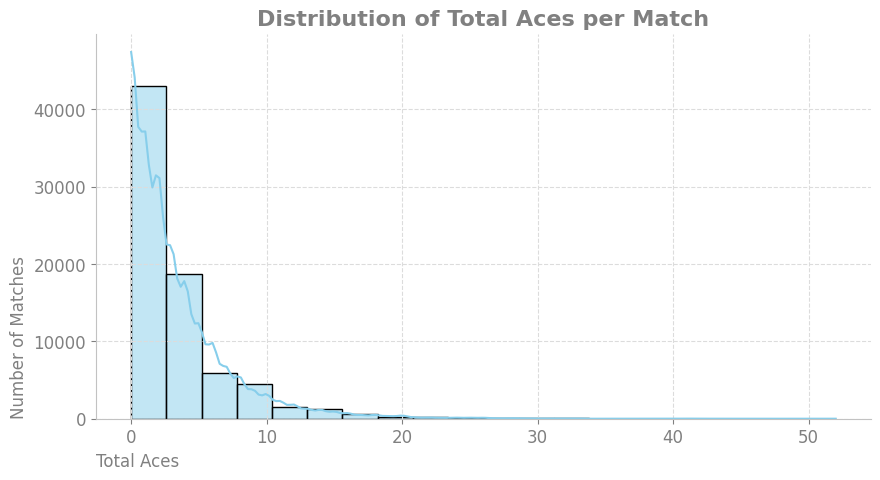

In [14]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(aces_df['total_aces'],
             kde=True,
             bins = 20,
             color="skyblue")

ax.spines[["right", "top"]].set_visible(False)
ax.spines[["left", "bottom"]].set_color("#c2c2c2")

ax.set_title("Distribution of Total Aces per Match",
             weight="bold",
             color="grey",
             fontsize=16)

ax.set_xlabel("Total Aces", loc="left", fontsize=12, color="grey")
ax.set_ylabel("Number of Matches", loc="bottom", fontsize=12, color="grey")

ax.tick_params(axis="x", colors="grey", labelsize="large")
ax.tick_params(axis="y", colors="grey", labelsize="large")

ax.grid(linestyle="dashed", color="gainsboro")

plt.savefig("../outputs/figures/totalAcePerMath.png", dpi=300)
plt.show()